In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

sys.path.append(str(Path("..").resolve()))
from config.settings import DATA_RAW, DATA_PROCESSED, SMMLV, SPLITTING_WINDOWS_DAYS, THRESHOLD_PROXIMITY_PCT

pd.set_option("display.float_format", "{:,.2f}".format)
print("✅ Imports OK")

✅ Imports OK


In [3]:
fm = pd.read_parquet(DATA_PROCESSED / "anomaly_scores.parquet")

# Date column was dropped — pull it back from raw data
raw = pd.read_parquet(DATA_RAW / "secop_raw.parquet", 
                      columns=["id_contrato", "fecha_de_inicio_del_contrato"])
fm = fm.merge(raw, on="id_contrato", how="left")

fm = fm.sort_values("fecha_de_inicio_del_contrato").reset_index(drop=True)

print(f"Loaded {len(fm):,} rows")
print(f"Date range: {fm['fecha_de_inicio_del_contrato'].min().date()} → {fm['fecha_de_inicio_del_contrato'].max().date()}")

Loaded 1,475,699 rows
Date range: 2019-01-01 → 2022-08-06


In [4]:
# Colombia's audit thresholds are expressed as multiples of SMMLV
# (Salario Mínimo Mensual Legal Vigente)
# Below these thresholds, contracts can bypass competitive bidding requirements
# Source: Law 80/1993 and annual decree modifications

# Threshold multiples by contract type (approximate, based on Law 80)
THRESHOLD_MULTIPLES = {
    "minima_cuantia": 28,        # Minimum amount — simplest process
    "menor_cuantia": 1000,       # Lesser amount — abbreviated process
    "mayor_cuantia": 10000,      # Greater amount — full public tender required
}

# Map SMMLV to each contract year
fm["smmlv"] = fm["year"].map(SMMLV)

# Compute thresholds in COP for each contract
fm["threshold_minima"] = fm["smmlv"] * THRESHOLD_MULTIPLES["minima_cuantia"]
fm["threshold_menor"]  = fm["smmlv"] * THRESHOLD_MULTIPLES["menor_cuantia"]
fm["threshold_mayor"]  = fm["smmlv"] * THRESHOLD_MULTIPLES["mayor_cuantia"]

# Distance to nearest relevant threshold (as fraction)
# Negative = below threshold, Positive = above threshold
fm["dist_to_minima"] = (fm["valor_del_contrato"] - fm["threshold_minima"]) / fm["threshold_minima"]
fm["dist_to_menor"]  = (fm["valor_del_contrato"] - fm["threshold_menor"])  / fm["threshold_menor"]

# Flag contracts within 10% BELOW each threshold (proximity zone)
fm["near_minima"] = (
    fm["dist_to_minima"].between(-THRESHOLD_PROXIMITY_PCT, 0)
).astype(int)

fm["near_menor"] = (
    fm["dist_to_menor"].between(-THRESHOLD_PROXIMITY_PCT, 0)
).astype(int)

fm["near_any_threshold"] = ((fm["near_minima"] == 1) | (fm["near_menor"] == 1)).astype(int)

print("Threshold proximity analysis:")
print(f"  Contracts near mínima cuantía threshold: {fm['near_minima'].sum():,} ({fm['near_minima'].mean()*100:.2f}%)")
print(f"  Contracts near menor cuantía threshold:  {fm['near_menor'].sum():,} ({fm['near_menor'].mean()*100:.2f}%)")
print(f"  Near any threshold:                      {fm['near_any_threshold'].sum():,} ({fm['near_any_threshold'].mean()*100:.2f}%)")

Threshold proximity analysis:
  Contracts near mínima cuantía threshold: 61,991 (4.20%)
  Contracts near menor cuantía threshold:  2,486 (0.17%)
  Near any threshold:                      64,477 (4.37%)


In [ ]:
# For each vendor-agency pair, count contracts and sum spend
# within rolling 30, 60, 90-day windows
# Flag pairs where multiple near-threshold contracts cluster together

print("Computing rolling window aggregation...")
print("This may take 2-3 minutes on 1.5M rows...\n")

# Work on direct awards only — splitting is only meaningful
# when the vendor is circumventing competitive thresholds
direct_contracts = fm[fm["is_direct"] == 1].copy()
direct_contracts = direct_contracts.sort_values("fecha_de_inicio_del_contrato")

print(f"Direct contracts to analyze: {len(direct_contracts):,}")

# Group by vendor-agency pair
# For each pair, compute rolling counts and sums
results = []

pair_groups = direct_contracts.groupby(["codigo_proveedor", "codigo_entidad"])
total_pairs = pair_groups.ngroups
print(f"Vendor-agency pairs: {total_pairs:,}")

# Only process pairs with at least 2 contracts — single contracts can't split
for (vendor, agency), group in pair_groups:
    if len(group) < 2:
        continue

    group = group.sort_values("fecha_de_inicio_del_contrato").reset_index(drop=True)
    dates = group["fecha_de_inicio_del_contrato"]
    values = group["valor_del_contrato"].values
    near_thresh = group["near_any_threshold"].values

    for i, (date, value) in enumerate(zip(dates, values)):
        for window_days in SPLITTING_WINDOWS_DAYS:
            # Find all contracts in the window ending at this contract
            window_start = date - pd.Timedelta(days=window_days)
            in_window = (dates >= window_start) & (dates <= date)
            window_contracts = in_window.sum()
            window_spend = values[in_window.values].sum()
            window_near_thresh = near_thresh[in_window.values].sum()

            if window_contracts >= 2 and window_near_thresh >= 2:
                results.append({
                    "codigo_proveedor": vendor,
                    "codigo_entidad": agency,
                    "anchor_date": date,
                    "window_days": window_days,
                    "window_contracts": window_contracts,
                    "window_spend": window_spend,
                    "window_near_thresh_count": window_near_thresh,
                })

print(f"\nSuspicious windows found: {len(results):,}")

Computing rolling window aggregation...
This may take 2-3 minutes on 1.5M rows...

Direct contracts to analyze: 1,336,662
Vendor-agency pairs: 627,877


In [ ]:
if len(results) == 0:
    print("⚠️ No suspicious windows found. Check threshold values.")
else:
    windows_df = pd.DataFrame(results)

    # Aggregate to vendor-agency pair level
    pair_scores = windows_df.groupby(["codigo_proveedor", "codigo_entidad"]).agg(
        total_suspicious_windows=("anchor_date", "count"),
        max_window_contracts=("window_contracts", "max"),
        total_flagged_spend=("window_spend", "max"),
        windows_30d=("window_days", lambda x: (x == 30).sum()),
        windows_60d=("window_days", lambda x: (x == 60).sum()),
        windows_90d=("window_days", lambda x: (x == 90).sum()),
    ).reset_index()

    # Splitting risk score — normalize to [0,1]
    pair_scores["splitting_score_raw"] = (
        pair_scores["total_suspicious_windows"] * 0.5 +
        pair_scores["max_window_contracts"] * 0.3 +
        pair_scores["total_flagged_spend"] / pair_scores["total_flagged_spend"].max() * 0.2
    )

    max_raw = pair_scores["splitting_score_raw"].max()
    pair_scores["splitting_score"] = pair_scores["splitting_score_raw"] / max_raw

    pair_scores = pair_scores.sort_values("splitting_score", ascending=False)

    print(f"Vendor-agency pairs with splitting signals: {len(pair_scores):,}")
    print(f"\nTop 20 most suspicious vendor-agency pairs:\n")
    print(pair_scores.head(20)[
        ["codigo_proveedor", "codigo_entidad",
         "total_suspicious_windows", "max_window_contracts",
         "total_flagged_spend", "splitting_score"]
    ].to_string(index=False))

Vendor-agency pairs with splitting signals: 764

Top 20 most suspicious vendor-agency pairs:

codigo_proveedor codigo_entidad  total_suspicious_windows  max_window_contracts  total_flagged_spend  splitting_score
       711240846      700077019                       792                   184         328284131440             1.00
       702451410      700619018                       192                   176           3281477856             0.33
       702271859      704155167                       228                    76          41570805032             0.30
       702271859      704148691                       228                    44          35329179872             0.28
       704196096      702727819                       144                    52           4481050768             0.19
       702730953      700619018                       132                    68           2258364800             0.19
       702266370      702730482                       120                    48 

In [ ]:
# Every contract belonging to a flagged pair inherits the pair's score
fm = fm.merge(
    pair_scores[["codigo_proveedor", "codigo_entidad", "splitting_score"]],
    on=["codigo_proveedor", "codigo_entidad"],
    how="left"
)

fm["splitting_score"] = fm["splitting_score"].fillna(0)

print("Splitting score distribution:")
print(f"  Contracts with score > 0:    {(fm['splitting_score'] > 0).sum():,} ({(fm['splitting_score'] > 0).mean()*100:.1f}%)")
print(f"  Contracts with score > 0.5:  {(fm['splitting_score'] > 0.5).sum():,} ({(fm['splitting_score'] > 0.5).mean()*100:.1f}%)")
print(f"  Mean score:                  {fm['splitting_score'].mean():.4f}")
print(f"  Max score:                   {fm['splitting_score'].max():.4f}")

# Sanity check — what fraction of spend is covered by flagged pairs?
flagged_spend = fm[fm["splitting_score"] > 0]["valor_del_contrato"].sum()
total_spend = fm["valor_del_contrato"].sum()
print(f"\n  Flagged spend share: {flagged_spend/total_spend*100:.1f}% of total")
print(f"  (Expected range from literature: 5-15%)")

Splitting score distribution:
  Contracts with score > 0:    12,487 (0.8%)
  Contracts with score > 0.5:  372 (0.0%)
  Mean score:                  0.0007
  Max score:                   1.0000

  Flagged spend share: 7.2% of total
  (Expected range from literature: 5-15%)


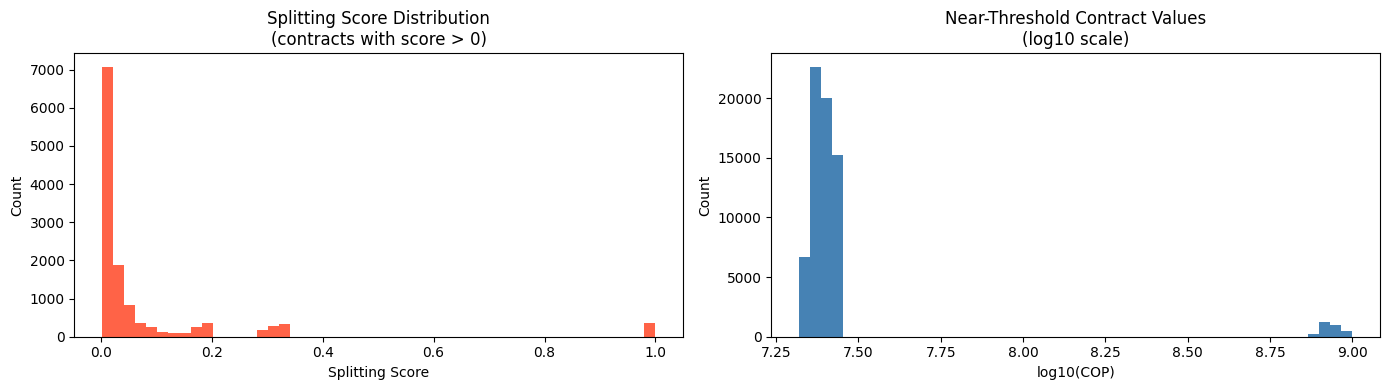

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Distribution of splitting scores
axes[0].hist(fm[fm["splitting_score"] > 0]["splitting_score"],
             bins=50, color="tomato", edgecolor="none")
axes[0].set_title("Splitting Score Distribution\n(contracts with score > 0)")
axes[0].set_xlabel("Splitting Score")
axes[0].set_ylabel("Count")

# Near-threshold contract value distribution
near = fm[fm["near_any_threshold"] == 1]["valor_del_contrato"]
axes[1].hist(np.log10(near.clip(lower=1)), bins=50,
             color="steelblue", edgecolor="none")
axes[1].set_title("Near-Threshold Contract Values\n(log10 scale)")
axes[1].set_xlabel("log10(COP)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig("../outputs/charts/05_splitting_analysis.png", dpi=150)
plt.show()

In [ ]:
output_path = DATA_PROCESSED / "splitting_scores.parquet"
fm.to_parquet(output_path, index=False, compression="snappy")

print("=" * 55)
print("✅ SPLITTING DETECTION COMPLETE")
print("=" * 55)
print(f"  Contracts analyzed:          {len(fm):,}")
print(f"  Suspicious pairs found:      {len(pair_scores):,}")
print(f"  Contracts with score > 0:    {(fm['splitting_score'] > 0).sum():,}")
print(f"  Flagged spend share:         {flagged_spend/total_spend*100:.1f}%")
print(f"  Saved to:                    {output_path}")
print("=" * 55)

✅ SPLITTING DETECTION COMPLETE
  Contracts analyzed:          1,553,594
  Suspicious pairs found:      764
  Contracts with score > 0:    12,487
  Flagged spend share:         7.2%
  Saved to:                    C:\Users\HP\Collections\VsCode Projects\AuditLens\data\processed\splitting_scores.parquet
